<a href="https://colab.research.google.com/github/Amirgh8080/My-SLFEND/blob/main/Final_SLFEND.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [45]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer

## Load Data


In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
!mkdir /.kaggle
!mv kaggle.json /.kaggle
!mv /.kaggle /root/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [64]:
!kaggle datasets download -d emineyetm/fake-news-detection-datasets

Dataset URL: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets
License(s): unknown
fake-news-detection-datasets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [65]:
!unzip fake-news-detection-datasets.zip


Archive:  fake-news-detection-datasets.zip
replace News _dataset/Fake.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace News _dataset/True.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [67]:
import pandas as pd
path = '/content/drive/MyDrive/Datasets/Fake_Real_Data.csv'
df = pd.read_csv(path)

## Preprocess

In [68]:
df['label'] = df['label'].map({'Real': 0, 'Fake': 1})
df.head()


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,1
1,U.S. conservative leader optimistic of common ...,0
2,"Trump proposes U.S. tax overhaul, stirs concer...",0
3,Court Forces Ohio To Allow Millions Of Illega...,1
4,Democrats say Trump agrees to work on immigrat...,0


In [56]:
def preprocess_data(df, text_column, label_column):
    """Preprocess data, converting text and labels to lists."""
    df = df.dropna(subset=[text_column, label_column])
    df[label_column] = df[label_column].apply(lambda x: 1 if x == 'Real' else 0)
    texts = df[text_column].tolist()
    labels = df[label_column].tolist()
    return texts, labels

In [57]:
class NewsDataset(Dataset):
    """Custom Dataset class for news data."""
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float)
        }

In [69]:
print(df.shape)
print(df['label'].value_counts())


(9900, 2)
label
1    5000
0    4900
Name: count, dtype: int64


## Faulty

In [ ]:
import torch
import torch.nn as nn
from transformers import BertTokenizer
from torch.utils.data import Dataset, DataLoader
import pandas as pd

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'label': torch.tensor(label, dtype=torch.float)
        }

def preprocess_data(df, text_column, label_column):
    df = df.dropna(subset=[text_column, label_column])
    df[label_column] = df[label_column].apply(lambda x: 1 if x == 'Real' else 0)
    texts = df[text_column].tolist()
    labels = df[label_column].tolist()
    return texts, labels
from transformers import BertModel

class BertEmbedding(nn.Module):
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(BertEmbedding, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # [batch_size, seq_len, 768]
class LeapGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LeapGRU, self).__init__()
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2 + input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        outputs = []

        for t in range(seq_len):
            ht = self.gru(x[:, t, :], h)
            context = torch.cat([h, ht, x[:, t, :]], dim=-1)
            skip_prob = self.mlp(context)[:, 1]  # Skip probability

            if skip_prob.mean() >= 0.5:
                h = ht  # Update hidden state only if skip_prob is high

            outputs.append(h)

        outputs = torch.stack(outputs, dim=1)
        return outputs  # [batch_size, seq_len, hidden_size]
class MembershipFunction(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MembershipFunction, self).__init__()
        self.leap_gru = LeapGRU(input_size, hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 9),  # Output for 9 domains
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        leap_output = self.leap_gru(x)
        h = leap_output[:, -1, :]  # Final hidden state
        soft_labels = self.mlp(h)
        return soft_labels  # [batch_size, 9]
class TextCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(1, 100, (k, input_size)) for k in [3, 4, 5]
        ])
        self.fc = nn.Linear(300, num_classes)  # 100*3 filters
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, seq_len, input_size]
        conv_results = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [torch.max(result, dim=2)[0] for result in conv_results]
        cat = torch.cat(pooled, dim=1)
        out = self.dropout(self.fc(cat))
        return out  # [batch_size, num_classes]
class DomainGate(nn.Module):
    def __init__(self, input_size):
        super(DomainGate, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 9),
            nn.Softmax(dim=-1)
        )

    def forward(self, g):
        alpha = self.mlp(g)
        return alpha  # [batch_size, 9]
class Classifier(nn.Module):
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 384),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(384, 1),
            nn.Sigmoid()
        )

    def forward(self, v):
        return self.mlp(v).squeeze(-1)  # [batch_size]
class SLFENDModel(nn.Module):
    def __init__(self):
        super(SLFENDModel, self).__init__()
        self.bert = BertEmbedding()
        self.membership_function = MembershipFunction(input_size=768, hidden_size=256)
        self.experts = nn.ModuleList([TextCNN(768, 128) for _ in range(9)])
        self.domain_gate = DomainGate(9)
        self.classifier = Classifier(128)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask)  # [batch_size, seq_len, 768]
        soft_labels = self.membership_function(bert_output)  # [batch_size, 9]

        expert_outputs = [expert(bert_output) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)  # [batch_size, 9, 128]

        alpha = self.domain_gate(soft_labels).unsqueeze(-1)  # [batch_size, 9, 1]
        v = (expert_outputs * alpha).sum(dim=1)  # Weighted sum of expert outputs

        y_hat = self.classifier(v)
        return y_hat  # [batch_size]
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=2e-5):
    criterion = nn.BCELoss()

    # Add weight decay (L2 regularization) in the optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

    # Add learning rate scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)

    # Early stopping mechanism
    early_stopping = EarlyStopping(patience=3)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_acc = 0, 0

        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.round().detach().cpu().numpy()
            acc = accuracy_score(labels.cpu().numpy(), preds)
            total_acc += acc

        # Evaluate on validation data
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Acc: {total_acc/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Step the scheduler with the validation loss
        scheduler.step(val_loss)

        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break


def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.round().detach().cpu().numpy()
            acc = accuracy_score(labels.cpu().numpy(), preds)
            total_acc += acc

    return total_loss / len(val_loader), total_acc / len(val_loader)

# Early stopping helper class
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.best_loss = float('inf')
        self.epochs_no_improve = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.epochs_no_improve = 0
        else:
            self.epochs_no_improve += 1
            if self.epochs_no_improve >= self.patience:
                self.early_stop = True

# Load your data


texts, labels = preprocess_data(df, 'Text', 'label')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 170

# Splitting the data into training, validation, and test sets
train_texts, train_labels = texts[:int(0.8*len(texts))], labels[:int(0.8*len(labels))]
val_texts, val_labels = texts[int(0.8*len(texts)):int(0.9*len(texts))], labels[int(0.8*len(labels)):int(0.9*len(labels))]
test_texts, test_labels = texts[int(0.9*len(texts)):], labels[int(0.9*len(labels)):]

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_len)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize and train the model
model = SLFENDModel()
train_model(model, train_loader, val_loader)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

NameError: name 'accuracy_score' is not defined

# Current

## Original Paper

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Model Architecture ---
class BertEmbedding(nn.Module):
    """BERT encoder to extract textual embeddings."""
    def __init__(self, bert_model_name='bert-base-uncased'):
        super(BertEmbedding, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return outputs.last_hidden_state  # Return hidden states [batch_size, seq_len, hidden_size]

class LeapGRU(nn.Module):
    """Leap GRU module for skipping irrelevant words."""
    def __init__(self, input_size, hidden_size):
        super(LeapGRU, self).__init__()
        self.gru = nn.GRUCell(input_size, hidden_size)
        self.hidden_size = hidden_size
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size * 2 + input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.hidden_size).to(x.device)
        outputs = []

        for t in range(seq_len):
            ht = self.gru(x[:, t, :], h)
            context = torch.cat([h, ht, x[:, t, :]], dim=-1)
            skip_prob = self.mlp(context)[:, 1]  # Skip probability based on context

            if skip_prob.mean() >= 0.5:
                h = ht  # Update hidden state only if skip_prob is high

            outputs.append(h)

        outputs = torch.stack(outputs, dim=1)
        return outputs  # [batch_size, seq_len, hidden_size]

class MembershipFunction(nn.Module):
    """Generates soft labels for multi-domain fake news detection."""
    def __init__(self, input_size, hidden_size):
        super(MembershipFunction, self).__init__()
        self.leap_gru = LeapGRU(input_size, hidden_size)
        self.mlp = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Linear(128, 9),  # 9 domain labels (based on the paper)
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        leap_output = self.leap_gru(x)
        h = leap_output[:, -1, :]  # Final hidden state
        soft_labels = self.mlp(h)
        return soft_labels  # Soft labels [batch_size, 9]

class TextCNN(nn.Module):
    """Text CNN for feature extraction."""
    def __init__(self, input_size, num_classes):
        super(TextCNN, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(1, 100, (k, input_size)) for k in [3, 4, 5]
        ])
        self.fc = nn.Linear(300, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch_size, 1, seq_len, input_size]
        conv_results = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(result, result.size(2)).squeeze(2) for result in conv_results]
        cat = torch.cat(pooled, dim=1)
        out = self.dropout(self.fc(cat))
        return out  # [batch_size, num_classes]

class DomainGate(nn.Module):
    """Applies domain gate logic to weigh experts' outputs."""
    def __init__(self, input_size):
        super(DomainGate, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 9),  # 9 domains
            nn.Softmax(dim=-1)
        )

    def forward(self, g):
        alpha = self.mlp(g)
        return alpha  # Soft domain weights [batch_size, 9]

class Classifier(nn.Module):
    """Final classifier for detecting fake news."""
    def __init__(self, input_size):
        super(Classifier, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 384),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(384, 1),
            nn.Sigmoid()
        )

    def forward(self, v):
        return self.mlp(v).squeeze(-1)  # Output fake/real label [batch_size]

class SLFENDModel(nn.Module):
    """Soft-label multi-domain fake news detection (SLFEND) model."""
    def __init__(self):
        super(SLFENDModel, self).__init__()
        self.bert = BertEmbedding()
        self.membership_function = MembershipFunction(input_size=768, hidden_size=256)
        self.experts = nn.ModuleList([TextCNN(768, 128) for _ in range(9)])  # 9 expert networks
        self.domain_gate = DomainGate(9)
        self.classifier = Classifier(128)  # Classify final weighted output

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask)  # [batch_size, seq_len, 768]
        soft_labels = self.membership_function(bert_output)  # [batch_size, 9]

        # Pass through expert networks
        expert_outputs = [expert(bert_output) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)  # [batch_size, 9, 128]

        # Apply domain gate weights
        alpha = self.domain_gate(soft_labels).unsqueeze(-1)  # [batch_size, 9, 1]
        v = (expert_outputs * alpha).sum(dim=1)  # Weighted sum of expert outputs

        # Classification
        y_hat = self.classifier(v)
        return y_hat  # [batch_size]



In [15]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=2e-5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            preds = outputs.round().detach().cpu().numpy()
            acc = accuracy_score(labels.cpu().numpy(), preds)
            total_acc += acc

        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Acc: {total_acc/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

def evaluate_model(model, val_loader, criterion):
    model.eval()
    total_loss, total_acc = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.round().detach().cpu().numpy()
            acc = accuracy_score(labels.cpu().numpy(), preds)
            total_acc += acc

    return total_loss / len(val_loader), total_acc / len(val_loader)



texts, labels = preprocess_data(df, 'Text', 'label')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 170

# Splitting the data into training, validation, and test sets
train_texts, train_labels = texts[:int(0.8*len(texts))], labels[:int(0.8*len(labels))]
val_texts, val_labels = texts[int(0.8*len(texts)):int(0.9*len(texts))], labels[int(0.8*len(labels)):int(0.9*len(labels))]
test_texts, test_labels = texts[int(0.9*len(texts)):], labels[int(0.9*len(labels)):]

train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_len)
test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize and train the model
model = SLFENDModel()
train_model(model, train_loader, val_loader)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/10, Loss: 0.0378, Acc: 0.9994, Val Loss: 0.0003, Val Acc: 1.0000
Epoch 2/10, Loss: 0.0001, Acc: 1.0000, Val Loss: 0.0001, Val Acc: 1.0000
Epoch 3/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 4/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 5/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 6/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 7/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 8/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 9/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000
Epoch 10/10, Loss: 0.0000, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000


## Train paper

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("Original dataset class distribution:", dict(zip(*np.unique(labels, return_counts=True))))

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df.Text, df.label, test_size=0.3, stratify=labels, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


print_dataset_info("Train", train_texts, train_labels)
print_dataset_info("Validation", val_texts, val_labels)
print_dataset_info("Test", test_texts, test_labels)



Original dataset class distribution: {0: 9900}
Train Dataset Size: 6930
Class Distribution: {0: 3415, 1: 3515}

Validation Dataset Size: 1485
Class Distribution: {0: 742, 1: 743}

Test Dataset Size: 1485
Class Distribution: {0: 743, 1: 742}



In [ ]:


print("Original dataset class distribution:")
print("\n", dict(zip(*np.unique(df.label, return_counts=True))))

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df.Text, df.label, test_size=0.3, stratify=df.label, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

def print_dataset_info(name, texts, labels):
    print(f"\n{name} Dataset")
    print("-------------------------------")
    print(f"Size: {len(texts)}")
    class_dist = dict(zip(*np.unique(labels, return_counts=True)))
    for key, value in class_dist.items():
        print(f"Class {key}: {value} samples")
    print("-------------------------------\n")

print_dataset_info("Train", train_texts, train_labels)
print_dataset_info("Validation", val_texts, val_labels)
print_dataset_info("Test", test_texts, test_labels)

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512, return_tensors="pt")
        self.labels = torch.tensor(list(labels), dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'label': self.labels[idx]
        }

train_dataset = NewsDataset(train_texts, train_labels)
val_dataset = NewsDataset(val_texts, val_labels)
test_dataset = NewsDataset(test_texts, test_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load SLFEND Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SLFENDModel().to(device)


def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=2e-5):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        total_loss, total_acc = 0, 0
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            preds = (outputs > 0.5).float().cpu().numpy()
            acc = accuracy_score(labels.cpu().numpy(), preds)
            total_acc += acc
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {total_loss/len(train_loader):.4f} - Accuracy: {total_acc/len(train_loader):.4f}")

def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).unsqueeze(1)
            outputs = model(input_ids, attention_mask)
            preds = (outputs > 0.5).float().cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    print("\nEvaluation Metrics:")
    print("-------------------------------")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-------------------------------\n")
    return all_labels, all_preds

# Train model
train_model(model, train_loader, val_loader, num_epochs=5)

# Evaluate on test set
all_labels, all_preds = evaluate_model(model, test_loader)

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Original dataset class distribution:

 {0: 4900, 1: 5000}

Train Dataset
-------------------------------
Size: 6930
Class 0: 3430 samples
Class 1: 3500 samples
-------------------------------


Validation Dataset
-------------------------------
Size: 1485
Class 0: 735 samples
Class 1: 750 samples
-------------------------------


Test Dataset
-------------------------------
Size: 1485
Class 0: 735 samples
Class 1: 750 samples
-------------------------------



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       990

    accuracy                           1.00       990
   macro avg       1.00      1.00      1.00       990
weighted avg       1.00      1.00      1.00       990



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


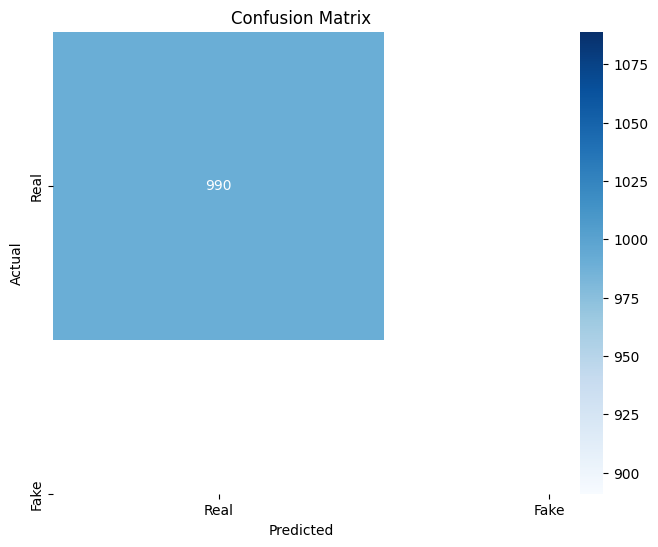

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_and_plot(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids, attention_mask)
            preds = outputs.round().detach().cpu().numpy()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds)

    print(classification_report(y_true, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

evaluate_and_plot(model, test_loader)


## Using Transformer instead of TextCNN

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # --------------------------
# # 1. Custom Dataset Class
# # --------------------------
# class TextDataset(Dataset):
#     def __init__(self, df, tokenizer, max_length=128):
#         self.texts = df['Text'].values
#         self.labels = df['label'].values
#         self.tokenizer = tokenizer
#         self.max_length = max_length

#     def __len__(self):
#         return len(self.texts)

#     def __getitem__(self, idx):
#         text = self.texts[idx]
#         label = self.labels[idx]

#         # Tokenize the text
#         encoding = self.tokenizer(
#             text,
#             max_length=self.max_length,
#             padding='max_length',
#             truncation=True,
#             return_tensors='pt'
#         )

#         # Move tensors to CUDA if available
#         return {
#             'input_ids': encoding['input_ids'].squeeze(0).to(device),
#             'attention_mask': encoding['attention_mask'].squeeze(0).to(device),
#             'label': torch.tensor(label, dtype=torch.float).to(device)
#         }

# # --------------------------
# # 2. Prepare DataLoader
# # --------------------------
# def prepare_dataloader(df, tokenizer, batch_size=16, max_length=128):
#     dataset = TextDataset(df, tokenizer, max_length)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     return dataloader

# # --------------------------
# # 3. Training Loop
# # --------------------------
def train_model(model, df, tokenizer, batch_size=16, epochs=10, lr=2e-5, max_length=128):
    # Prepare DataLoader
    dataloader = prepare_dataloader(df, tokenizer, batch_size, max_length)

    # Move model to CUDA
    model.to(device)

    # Optimizer and Loss Function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.BCELoss()

    # Training Loop
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['label']

            # Forward pass
            preds = model(input_ids, attention_mask)
            loss = loss_fn(preds, labels)

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # Track loss
            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

# --------------------------
# 4. Example Usage
# --------------------------

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = SLFEND()

# Train the model
train_model(model, df, tokenizer, batch_size=8, epochs=10, lr=2e-5, max_length=128)


model.safetensors:   0%|          | 0.00/412M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/10, Loss: 0.1393
Epoch 2/10, Loss: 0.0305
Epoch 3/10, Loss: 0.0024
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0001
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

# ----------------------
# 1. Leap GRU Component
# ----------------------
class LeapGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, cnn_filters=64):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.reverse_gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.cnn = nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1)

        # MLP for skip decision
        self.mlp = nn.Sequential(
            nn.Linear(input_dim + hidden_dim + (hidden_dim + cnn_filters), 128),
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=-1)
        )
        self.hidden_dim = hidden_dim
        self.cnn_filters = cnn_filters

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h_prev = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)
        reverse_out, _ = self.reverse_gru(torch.flip(x, dims=[1]))
        reverse_out = torch.flip(reverse_out, dims=[1])

        cnn_out = self.cnn(x.permute(0,2,1)).permute(0,2,1)

        outputs = []
        for t in range(seq_len):
            if t == 0:
                f_precede = torch.zeros(batch_size, self.hidden_dim).to(x.device)
            else:
                _, f_precede = self.gru(x[:, :t, :], h_prev)
                f_precede = f_precede.squeeze(0)

            if t < seq_len - 1:
                f_follow_gru = reverse_out[:, t+1, :]
                f_follow_cnn = cnn_out[:, t+1, :]
                f_follow = torch.cat([f_follow_gru, f_follow_cnn], dim=-1)
            else:
                f_follow = torch.zeros(batch_size, self.hidden_dim + self.cnn_filters).to(x.device)

            combined = torch.cat([x[:, t, :], f_precede, f_follow], dim=-1)
            pi_t = self.mlp(combined)

            if pi_t[0, 1] >= 0.5:
                _, h_prev = self.gru(x[:, t:t+1, :], h_prev)
                outputs.append(h_prev.squeeze(0))
            else:
                outputs.append(h_prev.squeeze(0))

        return torch.stack(outputs, dim=1)

# --------------------------
# 2. Membership Function
# --------------------------
class MembershipFunction(nn.Module):
    def __init__(self, input_dim, num_domains=9):
        super().__init__()
        self.leap_gru = LeapGRU(input_dim, hidden_dim=128)
        self.mlp = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, num_domains),
            nn.Softmax(dim=-1)
        )

    def forward(self, bert_embeddings):
        leap_out = self.leap_gru(bert_embeddings)
        pooled = torch.mean(leap_out, dim=1)
        soft_labels = self.mlp(pooled)
        return soft_labels

# --------------------------
# 3. Domain Gate
# --------------------------
class DomainGate(nn.Module):
    def __init__(self, num_domains=9, expert_dim=192):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_domains, 64),
            nn.ReLU(),
            nn.Linear(64, num_domains),
            nn.Softmax(dim=-1)
        )

    def forward(self, soft_labels):
        return self.mlp(soft_labels)

# --------------------------
# 4. Full SLFEND Model with Transformer
# --------------------------
class NewSLFEND(nn.Module):
    def __init__(self, num_domains=9):
        super().__init__()
        self.num_domains = num_domains
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.membership = MembershipFunction(768, num_domains)

        # Learnable domain tokens and transformer
        self.domain_tokens = nn.Parameter(torch.randn(1, num_domains, 768))
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=768,
            nhead=8,
            dim_feedforward=3072,
            dropout=0.1
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.domain_projection = nn.Linear(768, 192)

        self.domain_gate = DomainGate(num_domains)
        self.classifier = nn.Sequential(
            nn.Linear(192, 384),
            nn.ReLU(),
            nn.Linear(384, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        # BERT Embeddings
        bert_output = self.bert(input_ids, attention_mask)
        embeddings = bert_output.last_hidden_state
        batch_size = embeddings.size(0)

        # Soft Labels via Membership Function
        soft_labels = self.membership(embeddings)

        # Combine BERT embeddings with domain tokens
        domain_tokens = self.domain_tokens.expand(batch_size, -1, -1)
        combined = torch.cat([embeddings, domain_tokens], dim=1)

        # Transformer processing
        combined_permuted = combined.permute(1, 0, 2)
        transformer_output = self.transformer(combined_permuted)
        transformer_output = transformer_output.permute(1, 0, 2)

        # Extract and project domain features
        domain_features = transformer_output[:, -self.num_domains:, :]
        expert_outputs = self.domain_projection(domain_features)

        # Domain gating and classification
        alpha = self.domain_gate(soft_labels).unsqueeze(-1)
        combined = (expert_outputs * alpha).sum(dim=1)
        y_pred = self.classifier(combined)

        return y_pred.squeeze()

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------------------------
# 1. Custom Dataset Class
# --------------------------
class TextDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=128):
        self.texts = df['Text'].values
        self.labels = df['label'].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Move tensors to CUDA if available
        return {
            'input_ids': encoding['input_ids'].squeeze(0).to(device),
            'attention_mask': encoding['attention_mask'].squeeze(0).to(device),
            'label': torch.tensor(label, dtype=torch.float).to(device)
        }

# --------------------------
# 2. Prepare DataLoader
# --------------------------
def prepare_dataloader(df, tokenizer, batch_size=16, max_length=128):
    dataset = TextDataset(df, tokenizer, max_length)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

# Training Function
def train_model(model, dataloader, optimizer, criterion, device):
    dataloader = prepare_dataloader(df, tokenizer, batch_size, max_length)

    # Move model to CUDA
    model.to(device)

    model.train()
    total_loss = 0
    correct_predictions = 0

    for batch in dataloader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.round(outputs)
        correct_predictions += torch.sum(preds == labels).item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

# Evaluation Function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels.float())

            total_loss += loss.item()
            preds = torch.round(outputs)
            correct_predictions += torch.sum(preds == labels).item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy, all_preds, all_labels

# Plot Confusion Matrix
def plot_confusion_matrix(all_labels, all_preds):
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Main Script

    # Split Data

    # Tokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")

#     # Create Datasets and DataLoaders
# train_dataset = TextDataset(train_texts, train_labels, tokenizer)
# val_dataset = TextDataset(val_texts, val_labels, tokenizer)

# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Initialize Model, Optimizer, and Loss Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SLFEND(num_domains=9).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCELoss()

    # Training Loop
num_epochs = 5
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss, train_acc = train_model(
            model, train_dataloader, optimizer, criterion, device
        )
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")

        val_loss, val_acc, val_preds, val_labels = evaluate_model(
            model, val_dataloader, criterion, device
        )
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Evaluation Metrics
precision = precision_score(val_labels, val_preds)
recall = recall_score(val_labels, val_preds)
f1 = f1_score(val_labels, val_preds)
roc_auc = roc_auc_score(val_labels, val_preds)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

    # Plot Confusion Matrix
plot_confusion_matrix(val_labels, val_preds)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


NameError: name 'train_dataloader' is not defined

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

# ----------------------
# 1. Leap GRU Component
# ----------------------
class LeapGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, cnn_filters=64):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.reverse_gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.cnn = nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1)

        # MLP for skip decision (corrected input dimension)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim + hidden_dim + (hidden_dim + cnn_filters), 128),  # 768 + 128 + (128+64) = 1088
            nn.ReLU(),
            nn.Linear(128, 2),
            nn.Softmax(dim=-1)
        )
        self.hidden_dim = hidden_dim
        self.cnn_filters = cnn_filters  # Track CNN filters

    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        h_prev = torch.zeros(1, batch_size, self.hidden_dim).to(x.device)
        reverse_out, _ = self.reverse_gru(torch.flip(x, dims=[1]))
        reverse_out = torch.flip(reverse_out, dims=[1])

        cnn_out = self.cnn(x.permute(0,2,1)).permute(0,2,1)

        outputs = []
        for t in range(seq_len):
            # Preceding features (GRU up to t-1)
            if t == 0:
                f_precede = torch.zeros(batch_size, self.hidden_dim).to(x.device)
            else:
                _, f_precede = self.gru(x[:, :t, :], h_prev)
                f_precede = f_precede.squeeze(0)

            # Following features (reverse GRU and CNN)
            if t < seq_len - 1:
                f_follow_gru = reverse_out[:, t+1, :]
                f_follow_cnn = cnn_out[:, t+1, :]
                f_follow = torch.cat([f_follow_gru, f_follow_cnn], dim=-1)
            else:
                f_follow = torch.zeros(batch_size, self.hidden_dim + self.cnn_filters).to(x.device)  # 128 + 64

            # Skip decision
            combined = torch.cat([x[:, t, :], f_precede, f_follow], dim=-1)
            pi_t = self.mlp(combined)

            if pi_t[0, 1] >= 0.5:  # Process normally
                _, h_prev = self.gru(x[:, t:t+1, :], h_prev)
                outputs.append(h_prev.squeeze(0))
            else:  # Skip
                outputs.append(h_prev.squeeze(0))

        return torch.stack(outputs, dim=1)
# --------------------------
# 2. Membership Function
# --------------------------
class MembershipFunction(nn.Module):
    def __init__(self, input_dim, num_domains=9):
        super().__init__()
        self.leap_gru = LeapGRU(input_dim, hidden_dim=128)
        self.mlp = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, num_domains),
            nn.Softmax(dim=-1)
        )

    def forward(self, bert_embeddings):
        leap_out = self.leap_gru(bert_embeddings)
        pooled = torch.mean(leap_out, dim=1)
        soft_labels = self.mlp(pooled)
        return soft_labels
# --------------------------
# 3. Expert Groups (TextCNN, DCNN, DPCNN)
# --------------------------
class TextCNN(nn.Module):
    def __init__(self, embed_dim, num_filters=64, kernel_sizes=[3,4,5]):
        super().__init__()
        self.convs = nn.ModuleList([
            nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes
        ])

    def forward(self, x):
        x = x.permute(0,2,1)
        outputs = [F.relu(conv(x)) for conv in self.convs]
        outputs = [F.max_pool1d(out, out.shape[-1]).squeeze(-1) for out in outputs]
        return torch.cat(outputs, dim=-1)

class DCNN(nn.Module):
    # Dynamic CNN from Kalchbrenner et al. (2014)
    def __init__(self, embed_dim, num_filters=192):
        super().__init__()
        self.conv = nn.Conv1d(embed_dim, num_filters, 3, padding=1)
        self.fold = nn.Fold(output_size=(1, 1), kernel_size=(1, 1))

    def forward(self, x):
        x = self.conv(x.permute(0,2,1))
        return F.max_pool1d(x, x.shape[-1]).squeeze(-1)

class DPCNN(nn.Module):
    # Deep Pyramid CNN from Johnson & Zhang (2017)
    def __init__(self, embed_dim, num_filters=192):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv1d(embed_dim, num_filters, 3, padding=1),
            nn.ReLU(),
            nn.Conv1d(num_filters, num_filters, 3, padding=1),
            nn.ReLU()
        )

    def forward(self, x):
        x = x.permute(0,2,1)
        x = self.blocks(x)
        return F.max_pool1d(x, x.shape[-1]).squeeze(-1)

class ExpertGroup(nn.Module):
    def __init__(self, embed_dim):
        super().__init__()
        self.experts = nn.ModuleList([
            TextCNN(embed_dim),
            DCNN(embed_dim),
            DPCNN(embed_dim)
        ])

    def forward(self, x):
        expert_outputs = [expert(x) for expert in self.experts]
        return torch.mean(torch.stack(expert_outputs), dim=0)

# --------------------------
# 4. Domain Gate
# --------------------------
class DomainGate(nn.Module):
    def __init__(self, num_domains=9, expert_dim=192):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_domains, 64),
            nn.ReLU(),
            nn.Linear(64, num_domains),
            nn.Softmax(dim=-1)
        )

    def forward(self, soft_labels):
        return self.mlp(soft_labels)

# --------------------------
# 5. Full SLFEND Model
# --------------------------
class SLFEND(nn.Module):
    def __init__(self, num_domains=9):
        super().__init__()
        self.bert = BertModel.from_pretrained('bert-base-chinese')
        self.membership = MembershipFunction(768, num_domains)

        self.expert_groups = nn.ModuleList([
            ExpertGroup(768) for _ in range(num_domains)
        ])

        self.domain_gate = DomainGate(num_domains)
        self.classifier = nn.Sequential(
            nn.Linear(192, 384),
            nn.ReLU(),
            nn.Linear(384, 1),
            nn.Sigmoid()
        )

    def forward(self, input_ids, attention_mask):
        # BERT Embeddings
        bert_output = self.bert(input_ids, attention_mask)
        embeddings = bert_output.last_hidden_state
        # print(f'bert_output {bert_output}')
        # print(f'embeddings.shape{embeddings.shape}')
        # Soft Labels via Membership Function
        soft_labels = self.membership(embeddings)

        # Expert Group Features
        expert_outputs = [group(embeddings) for group in self.expert_groups]
        # print(f'expert_outputs.__len__{expert_outputs.__len__}')
        # print(f'expert_outputs[0].shape{expert_outputs[0].shape}')
        expert_outputs = torch.stack(expert_outputs, dim=1)  # [batch, num_domains, features]
        # print(f'expert_outputs.shape{expert_outputs.shape}')
        # Domain Gate Weights
        alpha = self.domain_gate(soft_labels).unsqueeze(-1)  # [batch, num_domains, 1]
        # print(f'alpha.shape{alpha.shape}')
        # Weighted Sum
        weighted = expert_outputs * alpha
        # print(f'weighted.shape{weighted.shape}')
        combined = weighted.sum(dim=1)
        # print(f'combined.shape{combined.shape}')
        # Classification
        y_pred = self.classifier(combined)
        return y_pred.squeeze()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'label

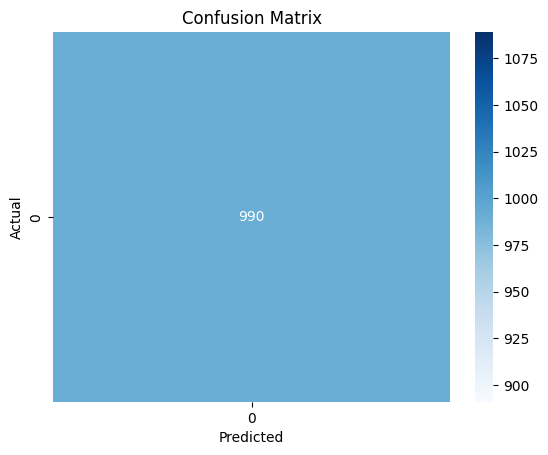

Epoch 1/10, Loss: 0.0142, Acc: 0.9992, Val Loss: 0.0002, Val Acc: 1.0000, Val F1: 0.0000, Val ROC-AUC: nan


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


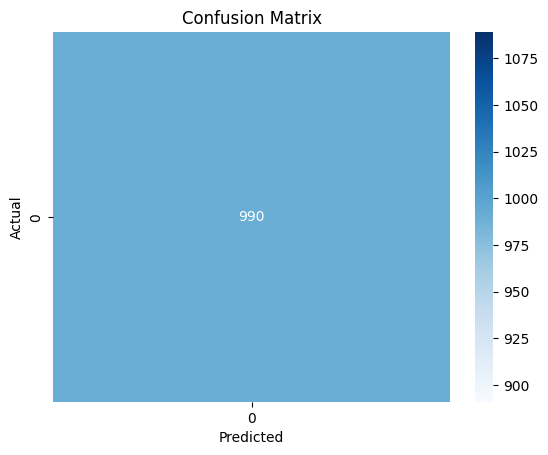

Epoch 2/10, Loss: 0.0002, Acc: 1.0000, Val Loss: 0.0000, Val Acc: 1.0000, Val F1: 0.0000, Val ROC-AUC: nan


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# # --- Model Architecture ---
# class BertEmbedding(nn.Module):
#     """BERT encoder to extract textual embeddings."""
#     def __init__(self, bert_model_name='bert-base-uncased'):
#         super(BertEmbedding, self).__init__()
#         self.bert = BertModel.from_pretrained(bert_model_name)

#     def forward(self, input_ids, attention_mask):
#         outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
#         return outputs.last_hidden_state  # Return hidden states [batch_size, seq_len, hidden_size]

# class LeapGRU(nn.Module):
#     """Leap GRU module for skipping irrelevant words."""
#     def __init__(self, input_size, hidden_size):
#         super(LeapGRU, self).__init__()
#         self.gru = nn.GRUCell(input_size, hidden_size)
#         self.hidden_size = hidden_size
#         self.mlp = nn.Sequential(
#             nn.Linear(hidden_size * 2 + input_size, 128),
#             nn.ReLU(),
#             nn.Linear(128, 2),
#             nn.Softmax(dim=-1)
#         )

#     def forward(self, x):
#         batch_size, seq_len, _ = x.size()
#         h = torch.zeros(batch_size, self.hidden_size).to(x.device)
#         outputs = []

#         for t in range(seq_len):
#             ht = self.gru(x[:, t, :], h)
#             context = torch.cat([h, ht, x[:, t, :]], dim=-1)
#             skip_prob = self.mlp(context)[:, 1]  # Skip probability based on context

#             if skip_prob.mean() >= 0.5:
#                 h = ht  # Update hidden state only if skip_prob is high

#             outputs.append(h)

#         outputs = torch.stack(outputs, dim=1)
#         return outputs  # [batch_size, seq_len, hidden_size]

# class MembershipFunction(nn.Module):
#     """Generates soft labels for multi-domain fake news detection."""
#     def __init__(self, input_size, hidden_size):
#         super(MembershipFunction, self).__init__()
#         self.leap_gru = LeapGRU(input_size, hidden_size)
#         self.mlp = nn.Sequential(
#             nn.Linear(hidden_size, 128),
#             nn.ReLU(),
#             nn.Linear(128, 9),  # 9 domain labels (based on the paper)
#             nn.Softmax(dim=-1)
#         )

#     def forward(self, x):
#         leap_output = self.leap_gru(x)
#         h = leap_output[:, -1, :]  # Final hidden state
#         soft_labels = self.mlp(h)
#         return soft_labels  # Soft labels [batch_size, 9]

class TransformerExpert(nn.Module):
    """Transformer-based expert for feature extraction."""
    def __init__(self, input_size, num_classes):
        super(TransformerExpert, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=input_size, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=2)
        self.fc = nn.Linear(input_size, num_classes)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.permute(1, 0, 2)  # Transformer expects [seq_len, batch_size, input_size]
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Back to [batch_size, seq_len, input_size]
        x = x.mean(dim=1)  # Global average pooling
        out = self.dropout(self.fc(x))
        return out  # [batch_size, num_classes]

class DomainGate(nn.Module):
    """Applies domain gate logic to weigh experts' outputs."""
    def __init__(self, input_size):
        super(DomainGate, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 9),  # 9 domains
            nn.Softmax(dim=-1)
        )

    def forward(self, g):
        alpha = self.mlp(g)
        return alpha  # Soft domain weights [batch_size, 9]

# class Classifier(nn.Module):
#     """Final classifier for detecting fake news."""
#     def __init__(self, input_size):
#         super(Classifier, self).__init__()
#         self.mlp = nn.Sequential(
#             nn.Linear(input_size, 384),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(384, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, v):
#         return self.mlp(v).squeeze(-1)  # Output fake/real label [batch_size]

class SLFENDModel(nn.Module):
    """Soft-label multi-domain fake news detection (SLFEND) model."""
    def __init__(self):
        super(SLFENDModel, self).__init__()
        self.bert = BertEmbedding()
        self.membership_function = MembershipFunction(input_size=768, hidden_size=256)
        self.experts = nn.ModuleList([TransformerExpert(768, 128) for _ in range(9)])  # 9 expert networks
        self.domain_gate = DomainGate(9)
        self.classifier = Classifier(128)  # Classify final weighted output

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask)  # [batch_size, seq_len, 768]
        soft_labels = self.membership_function(bert_output)  # [batch_size, 9]

        # Pass through expert networks
        expert_outputs = [expert(bert_output) for expert in self.experts]
        expert_outputs = torch.stack(expert_outputs, dim=1)  # [batch_size, 9, 128]

        # Apply domain gate weights
        alpha = self.domain_gate(soft_labels).unsqueeze(-1)  # [batch_size, 9, 1]
        v = (expert_outputs * alpha).sum(dim=1)  # Weighted sum of expert outputs

        # Classification
        y_hat = self.classifier(v)
        return y_hat  # [batch_size]

# # --- Training and Evaluation ---
# def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=2e-5):
#     criterion = nn.BCELoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.to(device)

#     for epoch in range(num_epochs):
#         model.train()
#         total_loss, total_acc = 0, 0
#         for batch in train_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['label'].to(device)

#             optimizer.zero_grad()
#             outputs = model(input_ids, attention_mask)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             total_loss += loss.item()
#             preds = outputs.round().detach().cpu().numpy()
#             acc = accuracy_score(labels.cpu().numpy(), preds)
#             total_acc += acc

#         val_loss, val_acc, val_f1, val_roc_auc = evaluate_model(model, val_loader, criterion)
#         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader):.4f}, Acc: {total_acc/len(train_loader):.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}, Val ROC-AUC: {val_roc_auc:.4f}')

# def evaluate_model(model, val_loader, criterion):
#     model.eval()
#     total_loss, total_acc, total_f1, total_roc_auc = 0, 0, 0, 0
#     all_preds, all_labels = [], []

#     with torch.no_grad():
#         for batch in val_loader:
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             labels = batch['label'].to(device)

#             outputs = model(input_ids, attention_mask)
#             loss = criterion(outputs, labels)
#             total_loss += loss.item()

#             preds = outputs.round().detach().cpu().numpy()
#             all_preds.extend(preds)
#             all_labels.extend(labels.cpu().numpy())

#             acc = accuracy_score(labels.cpu().numpy(), preds)
#             total_acc += acc

#     total_loss /= len(val_loader)
#     total_acc /= len(val_loader)
#     total_f1 = f1_score(all_labels, all_preds)
#     total_roc_auc = roc_auc_score(all_labels, all_preds)

#     # Plot confusion matrix
#     cm = confusion_matrix(all_labels, all_preds)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.xlabel('Predicted')
#     plt.ylabel('Actual')
#     plt.title('Confusion Matrix')
#     plt.show()

#     return total_loss, total_acc, total_f1, total_roc_auc

# # --- Example Usage ---

# texts, labels = preprocess_data(df, 'Text', 'label')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# max_len = 170

# # Splitting the data into training, validation, and test sets
# train_texts, train_labels = texts[:int(0.8*len(texts))], labels[:int(0.8*len(labels))]
# val_texts, val_labels = texts[int(0.8*len(texts)):int(0.9*len(texts))], labels[int(0.8*len(labels)):int(0.9*len(labels))]
# test_texts, test_labels = texts[int(0.9*len(texts)):], labels[int(0.9*len(labels)):]

# train_dataset = NewsDataset(train_texts, train_labels, tokenizer, max_len)
# val_dataset = NewsDataset(val_texts, val_labels, tokenizer, max_len)
# test_dataset = NewsDataset(test_texts, test_labels, tokenizer, max_len)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# # Initialize and train the model
# model = SLFENDModel()
# train_model(model, train_loader, val_loader)